In [158]:
import os
import sys
import requests
from dotenv import load_dotenv

import networkx as nx
from ipysigma import Sigma
import matplotlib
import matplotlib.colors as mpc

import seaborn as sns
import mercury

In [2]:
# Load app for json display
mercury.App(title="Display JSON", static_notebook=True)

# Load server environment
load_dotenv(os.path.dirname(sys.path[1]) + '/server/.env')

# Elastic search info
SCANR_API_URL = os.environ.get('SCANR_API_URL')
SCANR_API_TOKEN = os.environ.get('SCANR_API_TOKEN')
header = {'Authorization': SCANR_API_TOKEN}

mercury.App

In [13]:
# Keywords list
keywords = ["open science"]

DEFAULT_SIZE = 5000

# Create query block
must_block = []
for q in keywords :
    must_block.append( {
                    "query_string": {
                        "fields": ['title.*^3', 'authors.fullName^3', 'summary.*^2', 'domains.label.*^2'],
                        "query": f'"{q}"'
                    }})
print(must_block)

# Query json
json_query = {
        "size": 1,
        "query": {
            "bool": {
                "filter":[
                    {
                       "terms": {"year": [2018, 2019, 2020, 2021, 2022, 2023]}
                    } 
                ],
                "must": must_block
            }
        },
        "aggs": {
            "agg_authors": {
                "terms": {
                    "field": 'co_authors.keyword',
                    "size":DEFAULT_SIZE,
                },
                "aggs": {
                    "agg_year": {
                        "terms": {
                            "field": 'year'
                        }
                    }
                }
            },
            "agg_institutions": {
                "terms": {
                    "field": 'co_institutions.keyword',
                    "size": DEFAULT_SIZE,
                },
                "aggs": {
                    "agg_year": {
                        "terms": {
                            "field": 'year'
                        }
                    }
                }
            },
            "agg_structures": {
                "terms": {
                    "field": 'co_structures.keyword',
                    "size": DEFAULT_SIZE,
                },
                "aggs": {
                    "agg_year": {
                        "terms": {
                            "field": 'year'
                        }
                    }
                }
            },
            "agg_domains": {
                "terms": {
                    "field": 'co_domains.keyword',
                    "size": DEFAULT_SIZE,
                },
                "aggs": {
                    "agg_year": {
                        "terms": {
                            "field": 'year'
                        }
                    }
                }
            },
        },
}

# Request answer
json_answer = requests.post(SCANR_API_URL, json=json_query, headers=header).json()

[{'query_string': {'fields': ['title.*^3', 'authors.fullName^3', 'summary.*^2', 'domains.label.*^2'], 'query': '"open science"'}}]


In [9]:
mercury.JSON(json_answer)

In [15]:
a = json_answer.get("aggregations").get("agg_authors").get("buckets")[0]

In [67]:
def dict_from_bucket(bucket):
    return {item.get("key"):item.get("doc_count") for item in bucket}

def scale_avg_from_year_dict(year_dict, year_min=2018, year_max=2023):
    return (sum([k*year_dict.get(k) for k in year_dict.keys()])/sum(year_dict.values()) - year_min) / (year_max - year_min)

def scale_last_from_year_dict(year_dict, year_min=2018, year_max=2023):
    return (max([k for k in year_dict.keys()]) - year_min) / (year_max - year_min)


In [159]:
def graph_from_aggregation(bucket, components_n=3, last_year=2023):

  # Create graph
  G = nx.Graph()
  
  for item in bucket:
    nodes = item["key"].split('---')
    weight = item["doc_count"]
    years = item["agg_year"]["buckets"]

    # Year data
    year_dict = dict_from_bucket(years)
    # year_avg = scale_avg_from_year_dict(year_dict)
    year_last = scale_last_from_year_dict(year_dict)

    # Weight data
    nodes_weight = nx.get_node_attributes(G, "weight")
    edges_weight = nx.get_edge_attributes(G, "weight")

    # Color
    cmap = mpc.LinearSegmentedColormap.from_list("Custom", [(0.6, 0.6, 0.6), (0.17, 0.55, 0.01)])
    color1 = mpc.rgb2hex(cmap(year_last))
    
    # Add nodes
    for node in nodes:
      [id, label] = node.split("###")
      G.add_node(id, 
                 label=label,
                 weight=(nodes_weight.get(id) or 0) + weight,
                 year_last=year_last,
                 color1=color1)
    
    # Add edge
    G.add_edge(nodes[0].split("###")[0], nodes[1].split("###")[0], 
               weight=(edges_weight.get((nodes[0].split("###")[0], nodes[1].split("###")[0])) or 0) + weight)
    
  # Keep only largests components
  if components_n is not None:
    sorted_components = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph([node for component in sorted_components[0:components_n] for node in list(component)])

  print("Number of nodes", G.order())
  print("Number of edges", G.size())
  
  return G

In [160]:
G_authors = graph_from_aggregation(json_answer["aggregations"]["agg_authors"]["buckets"])

Number of nodes 311
Number of edges 1202


In [161]:
# Saturation with year
Sigma(G_authors, 
      node_size=G_authors.degree,
      node_metrics={"community": "louvain"},
      raw_node_color="color1",
      node_border_color_from="node",
      default_edge_type="curve",
      label_font="sans-serif",
      start_layout=5,
)

Sigma(nx.Graph with 311 nodes and 1,202 edges)

In [157]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors)
cm(0.5)

(0.5019607843137255, 0.0, 0.0, 1.0)

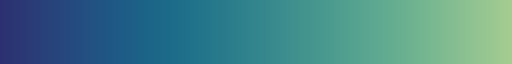

In [126]:
sns.color_palette("crest_r", as_cmap=True)

In [139]:
cmap = sns.color_palette("crest_r", as_cmap=True)
test = list(cmap(0.9))
test[3] = 0.1
test
matplotlib.colors.rgb2hex(test, keep_alpha=True)

'#89bf911a'

In [ ]:
# Saturation with last year
Sigma(G_authors, 
      node_size=G_authors.degree,
      node_metrics={"community": "louvain"},
      raw_node_color="#65bbe6",
      node_color_saturation="year_last",
      node_border_color_from="node",
      default_edge_type="curve",
    #   node_label_size=G_authors.degree,
      label_font="sans-serif",
      start_layout=5,
)

In [8]:
G_institutions = graph_from_aggregation(json_answer["aggregations"]["agg_institutions"]["buckets"], 1)

Number of nodes 678
Number of edges 4657


In [9]:
Sigma(G_institutions, 
      node_size=G_institutions.degree,
      node_metrics={"community": "louvain"},
      node_color="community",
      node_border_color_from="node",
      default_edge_type="curve",
    #   node_label_size=G_authors.degree,
      start_layout=5,
)

Sigma(nx.Graph with 678 nodes and 4,657 edges)

In [10]:
G_domains = graph_from_aggregation(json_answer["aggregations"]["agg_domains"]["buckets"], 3)

Number of nodes 260
Number of edges 614


In [11]:
Sigma(G_domains, 
      node_size=G_domains.degree,
      node_metrics={"community": "louvain"},
      node_color="community",
      node_border_color_from="node",
      default_edge_type="curve",
    #   node_label_size=G_authors.degree,
      start_layout=5,
)

Sigma(nx.Graph with 260 nodes and 614 edges)